Quelle: https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/

In [1]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)
from reader import Reader
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import cv2
import os
from skimage import exposure, transform

In [2]:
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join(["models", "detector3.h5"])
PLOT_PATH = os.path.sep.join(["images", "plot.png"])

In [3]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-3#4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [4]:
reader = Reader()
df = reader.read_data_to_df(folders=43, pre_path=r"../ML-Lab_data/data/")

C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df_tmp)
C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df_tmp)
C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df_tmp)
C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df_tmp)
C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df_tmp)
C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(df_tmp)
C:\Users\holz_so\Documents\Uni\MaschineLearning\verkehrsschilder\ML-Lab_project\src\reader.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

In [5]:
df

,Filename,Folder,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,../ML-Lab_data/data/0/,29,30,5,6,24,25,0
1,00000_00001.ppm,../ML-Lab_data/data/0/,30,30,5,5,25,25,0
2,00000_00002.ppm,../ML-Lab_data/data/0/,30,30,5,5,25,25,0
3,00000_00003.ppm,../ML-Lab_data/data/0/,31,31,5,5,26,26,0
4,00000_00004.ppm,../ML-Lab_data/data/0/,30,32,5,6,25,26,0
...,...,...,...,...,...,...,...,...,...
39204,00007_00025.ppm,../ML-Lab_data/data/42/,52,56,5,6,47,51,42
39205,00007_00026.ppm,../ML-Lab_data/data/42/,56,58,5,5,51,53,42
39206,00007_00027.ppm,../ML-Lab_data/data/42/,58,62,5,6,53,57,42
39207,00007_00028.ppm,../ML-Lab_data/data/42/,63,69,5,7,58,63,42


Ab hier für Training

In [6]:
data = []
targets = []

for index, row in df.iterrows(): 
    if index>0 and index%5000 == 0:
        print("Iterated through", index, "images")
    elif index+1 == len(df):
        print("Iterated through all images")
        
    width = row["Width"]
    height = row["Height"]
    x1 = row["Roi.X1"]
    y1 = row["Roi.Y1"]
    x2 = row["Roi.X2"]
    y2 = row["Roi.Y2"]
    
    h = y2-y1
    w = x2-x1
    
    startX = float(x1) / width
    startY = float(y1) / height
    endX = float(x2) / width
    endY = float(y2) / height
    
    data.append(Reader().read_preprocess_img_without_bounding(row["Folder"]+row["Filename"], (64,64)))
    targets.append((startX, startY, endX, endY))

data = np.array(data)
targets = np.array(targets)


Iterated through 5000 images
Iterated through 10000 images
Iterated through 15000 images
Iterated through 20000 images
Iterated through 25000 images
Iterated through 30000 images
Iterated through 35000 images
Iterated through all images


In [7]:
targets

array([[0.17241379, 0.2       , 0.82758621, 0.83333333],
       [0.16666667, 0.16666667, 0.83333333, 0.83333333],
       [0.16666667, 0.16666667, 0.83333333, 0.83333333],
       ...,
       [0.0862069 , 0.09677419, 0.9137931 , 0.91935484],
       [0.07936508, 0.10144928, 0.92063492, 0.91304348],
       [0.10294118, 0.08695652, 0.91176471, 0.91304348]])

In [8]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, test_size=0.25, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]


In [9]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
input_tensor=Input(shape=(64, 64, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(64, activation="relu")(flatten)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(16, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [10]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mae", optimizer=opt)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

C:\Users\holz_so\Anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    #batch_size=BATCH_SIZE,
    epochs=1,#NUM_EPOCHS,
    verbose=1)

[INFO] training bounding box regressor...
919/919 [==============================] - 670s 729ms/step - loss: 0.0321 - val_loss: 0.0299


[INFO] saving object detector model...


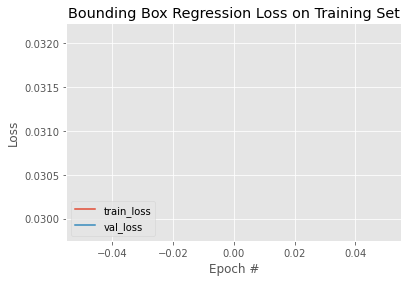

In [12]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

# plot the model training history
N = 1#NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

Ab hier für Testing:

In [ ]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
#print(model.summary())
# loop over the images that we'll be testing using our bounding box
# regression model

liste = [(row["Folder"]+"/"+row["Filename"], (row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"])) for _, row in df.iterrows()][::200]
liste = [("images/20_test_1.png", (0,0,1,1))]

for image_path, bounding in liste:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64,64))  # transform.resize??
    image = exposure.equalize_adapthist(image, clip_limit=0.05)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    # make bounding box predictions on the input image
    print("test")
    preds = model.predict(image)
    print(preds)
    (startX, startY, endX, endY) = preds[0]

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(image_path)
    #image = cv2.resize(image, (640, 640))
    (h, w) = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 1)
    cv2.rectangle(image, (bounding[0], bounding[1]), (bounding[2], bounding[3]), (0, 0, 255), 1)

    # show the output image
    cv2.imshow("Output", image)
    cv2.waitKey(0)

[INFO] loading object detector...
test
[[0.13413516 0.13563165 0.87378305 0.87773615]]
test
[[0.13395959 0.13537943 0.8740485  0.877921  ]]
test
[[0.13386893 0.13533467 0.8741472  0.8779533 ]]
test
[[0.13552901 0.1370162  0.87220556 0.87668395]]
test
[[0.13380036 0.13536039 0.87418616 0.8780026 ]]
test
[[0.13395882 0.13551691 0.87398505 0.8779385 ]]
test
[[0.13511822 0.1363692  0.872794   0.8770802 ]]
test
[[0.13416108 0.13558185 0.873871   0.8777259 ]]
test
[[0.1347991  0.13621747 0.8730421  0.8772767 ]]
test
[[0.13386515 0.13524649 0.8741562  0.87792236]]
test
[[0.13287938 0.13447517 0.8752408  0.8787521 ]]
test
[[0.13481489 0.13624743 0.87302095 0.8773148 ]]
test
[[0.13436863 0.13581133 0.87356305 0.8776234 ]]
test
[[0.13473266 0.13618082 0.87314576 0.877314  ]]
test
[[0.13359803 0.13508397 0.8744849  0.87811244]]
test
[[0.13356048 0.13503948 0.8744446  0.87822485]]
test
[[0.13358623 0.1350747  0.87440515 0.87820804]]
test
[[0.1346806  0.1361343  0.87315524 0.87734675]]
test
[[0.134